Importação das funções auxiliares e bibliotecas de aprendizade de máquina

In [1]:
from copy import deepcopy
from itertools import count
import random
from matplotlib.pyplot import axis
from sklearn.utils import shuffle
from math import ceil
import pandas as pd

def printa(a):
    print(a)
    return

def normalizaMinMax(coluna):
    minimo = coluna.min()
    maximo = coluna.max()
    return (coluna-minimo)/(maximo-minimo)

def split_in_folds(data, k):
    max_fold_size = ceil(data["id"].count()/k)
    folds = []
    for fold_index in range(k):
        folds.append([])
        for item_index in range(max_fold_size):
            item = data.sample()
            data.drop(item.index, inplace=True)
            folds[fold_index].append(item)
            if data.empty:
                break
    return folds

def merge_folds(folds):
    result = []
    for fold in folds:
        result += fold
    return result

def fold_to_df(fold):
    df = fold[0]
    for item_index in range(1, len(fold)):
        df = pd.concat([df, fold[item_index]])
    return df

def k_fold(data, k=5):
    data_clone = deepcopy(data)
    folds = split_in_folds(data_clone, k)
    fold_sets = []
    for fold_index, fold in enumerate(folds):
        test_fold = fold_to_df(fold)
        training_folds = deepcopy(folds)
        training_folds = training_folds[:fold_index]+training_folds[fold_index+1:]
        training_folds = merge_folds(training_folds)
        training_folds = fold_to_df(training_folds)
        fold_sets.append({'training_data': training_folds, 'test_data': test_fold})
    return fold_sets

def split_validation_df(data, percentage=0.1):
    model_df = deepcopy(data)
    validation_size = int(model_df["id"].count()*percentage)
    item = model_df.sample()
    validation_df = item
    model_df.drop(item.index, inplace=True)
    for item_index in range(1, validation_size):
        item = model_df.sample()
        validation_df = pd.concat([validation_df, item])
        model_df.drop(item.index, inplace=True)
    return validation_df, model_df


#def split_in_folds2(data, k):
#    max_fold_size = ceil(data["id"].count()/k)
#    folds = []
#    for fold_index in range(k):
#        folds.append([])
#        for item_index in range(max_fold_size):
#            item = data.sample()
#            id = item["id"]
#            data.drop(item.index)
#            folds[fold_index].append(id)
#            if data.empty:
#                break
#    return folds

#def k_fold2(data, k=5):
#    data_clone = deepcopy(data)
#    shuffle(data_clone)
#    folds = split_in_folds(data_clone, k)
#    fold_sets = []
#    for fold_index, fold in enumerate(folds):
#        test_fold = fold
#        training_folds = deepcopy(folds)
#        training_folds = training_folds[:fold_index]+training_folds[fold_index+1:]
#       fold_sets.append({'training_folds': training_folds, 'test_fold': test_fold})
#    return fold_sets

def get_confusion_matrix(tp, fn, fp, tn):
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_sensitivity(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])



In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



Importação dos dados

In [5]:
dados_entrada = pd.read_csv("data.csv")
dados_entrada.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


Analisando os dados

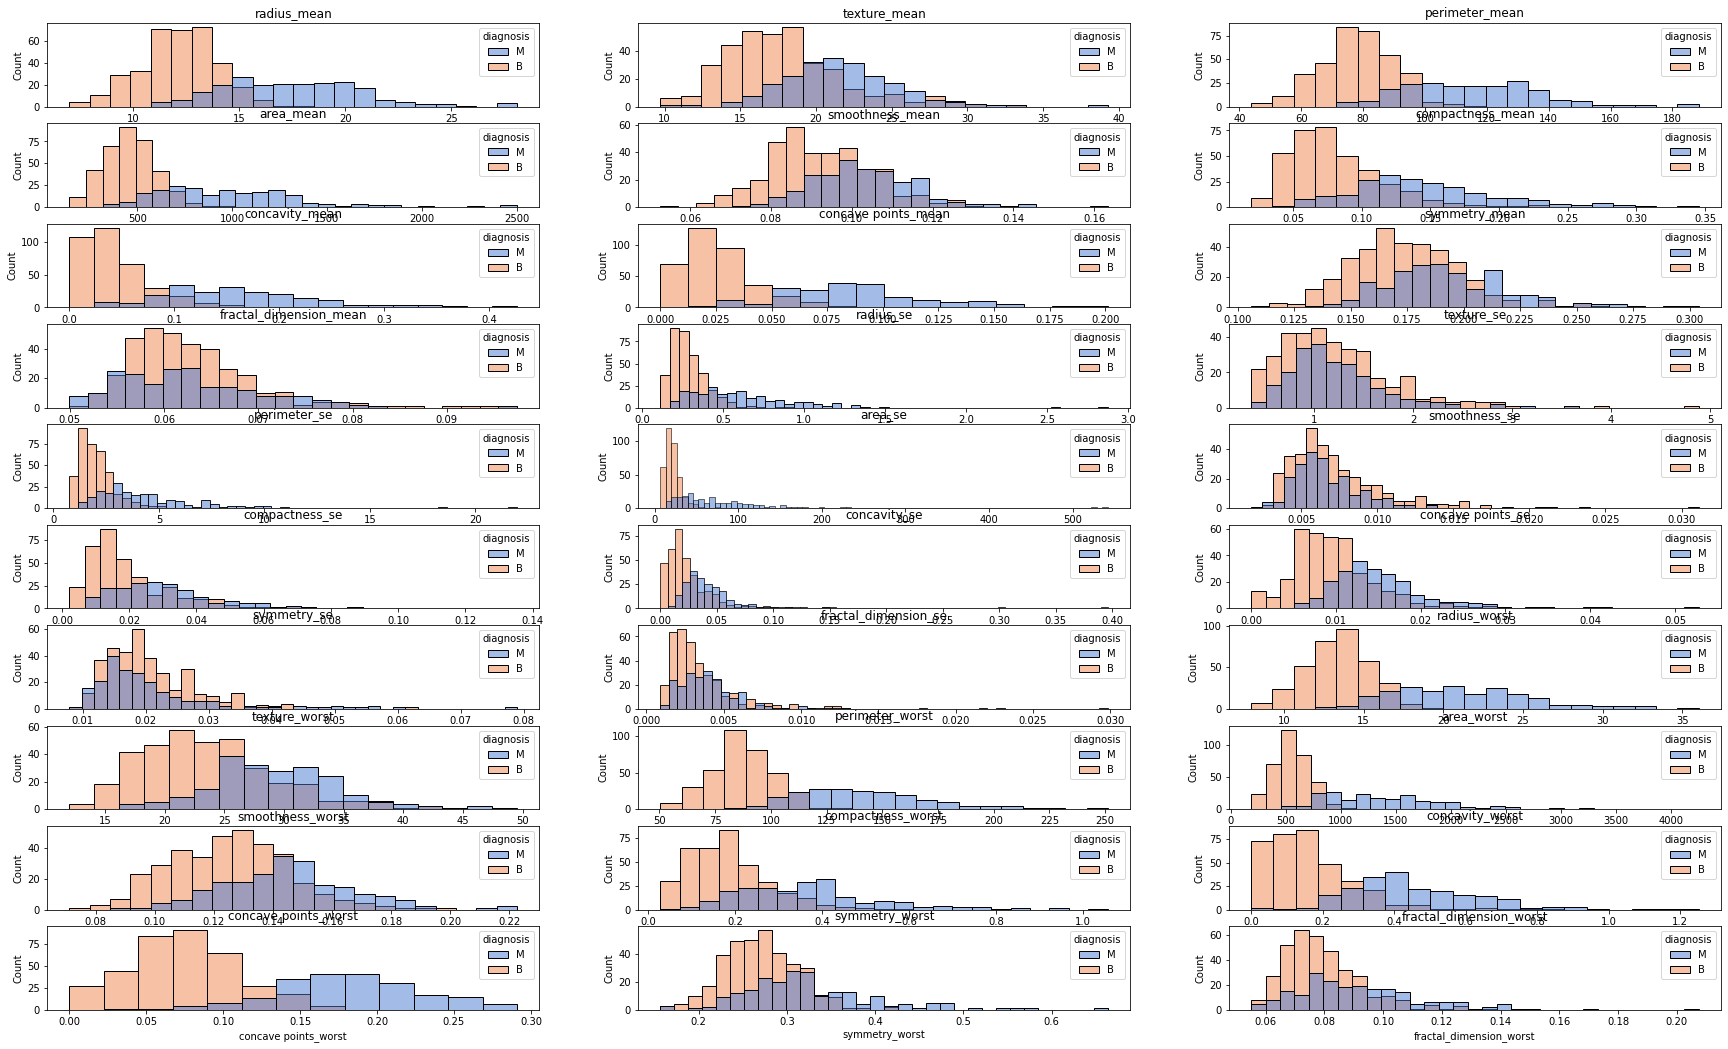

In [21]:
features = dados_entrada.columns
i = 0
lista_features = features.to_list()
lista_features.remove("diagnosis")
lista_features.remove("id")
lista_features.remove("Unnamed: 32")
his = plt.gcf()
his.set_size_inches(30, 20)
for feature in lista_features:
    i = i+1
    plt.subplot(11,3,i)
    sns.histplot(data = dados_entrada,x = feature, hue="diagnosis", palette="muted").set_title(feature)

Normalização os dados

In [39]:
dados_normalizados = dados_entrada.copy(deep = True)

lista_features = features.to_list()
lista_features.remove("diagnosis")
lista_features.remove("id")
lista_features.remove("Unnamed: 32")

for feature in lista_features:
    dados_normalizados[feature] = normalizaMinMax(dados_normalizados[feature])

dados_normalizados = dados_normalizados.drop("Unnamed: 32", axis = 1)
dados_normalizados.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.338222,0.323965,0.332935,0.216920,0.394785,0.260601,0.208058,0.243137,0.379605,...,0.296663,0.363998,0.283138,0.170906,0.404138,0.220212,0.217403,0.393836,0.263307,0.189596
std,1.250206e+08,0.166787,0.145453,0.167915,0.149274,0.126967,0.161992,0.186785,0.192857,0.138456,...,0.171940,0.163813,0.167352,0.139932,0.150779,0.152649,0.166633,0.225884,0.121954,0.118466
min,8.670000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.692180e+05,0.223342,0.218465,0.216847,0.117413,0.304595,0.139685,0.069260,0.100944,0.282323,...,0.180719,0.241471,0.167837,0.081130,0.300007,0.116337,0.091454,0.223127,0.185098,0.107700
50%,9.060240e+05,0.302381,0.308759,0.293345,0.172895,0.390358,0.224679,0.144189,0.166501,0.369697,...,0.250445,0.356876,0.235320,0.123206,0.397081,0.179110,0.181070,0.343402,0.247782,0.163977
75%,8.813129e+06,0.416442,0.408860,0.416765,0.271135,0.475490,0.340531,0.306232,0.367793,0.453030,...,0.386339,0.471748,0.373475,0.220901,0.494156,0.302520,0.305831,0.554639,0.318155,0.242949
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Separar o conjunto de validação

In [41]:
validacao_df, modelo_df = split_validation_df(dados_normalizados,0.2)
validacao_df.head

<bound method NDFrame.head of           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
540   921385         B     0.215770      0.159959        0.213254   0.110032   
338   897880         B     0.145251      0.264457        0.142492   0.070965   
191   875093         B     0.273984      0.395671        0.264184   0.154358   
398   904302         B     0.193052      0.173148        0.183263   0.099555   
307    89346         B     0.095556      0.158607        0.086863   0.043606   
..       ...       ...          ...           ...             ...        ...   
67    859465         B     0.204884      0.315522        0.193560   0.106299   
547   922840         B     0.155190      0.232330        0.152443   0.075207   
143   869224         B     0.280136      0.210010        0.276069   0.156394   
340    89813         B     0.352075      0.230977        0.348006   0.211113   
278  8911800         B     0.312793      0.274941        0.293345   0.181888   

     smoo

Primeiro Modelo

In [61]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=7)

TOTAL_FOLDS = 8
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0


for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["diagnosis"]
    knn_classifier.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["diagnosis"]
    print(knn_classifier.score(Xteste,yteste))
    score = score + knn_classifier.score(Xteste,yteste)

print("Acc média: " + (str(score/TOTAL_FOLDS)))

0.9824561403508771
0.9298245614035088
0.9649122807017544
0.9298245614035088
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9649122807017544
Acc média: 0.9649122807017542
